# Global Variable

In [ ]:
DATA_DIR='/content/gdrive/My Drive/crypto_data/' # data files location
Model_DIR='/content/gdrive/My Drive/crypto_data/models/' # model storage location
WINDOW_SIZE=8 # Size of window to predict the next data
BATCH_SIZE=32
LEARNING_RATE=0.01
TRAIN_RATE=0.8 # size of training data/size of all data
DEBUG=1 # 1 when DEBUG mode is on, 0 when DEBUG mode is off
DEBUG_RATE=0.05 # size of DEBUG data/size of all data
EPOCH_NUM=500

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# mount google drive

Mounted at /content/gdrive


# Unzip Files

In [ ]:
import zipfile
with zipfile.ZipFile(DATA_DIR+'output.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

# /content/drive/My Drive/crypto_data/output/tick-simple-YF-okef-btc.usd.q-2020-01-26.csv.gz

In [ ]:
import re
print(re.sub(r"(\.*).csv.gz", r"\1.csv", '/content/drive/My Drive/crypto_data/output/tick-simple-YF-okef-btc.usd.q-2020-01-26.csv.gz'))

In [ ]:
import re
import gzip
import shutil

from pathlib import Path

#解压gz文件
pathlist = Path(DATA_DIR+'output/').glob('*.csv.gz')
for path in pathlist:
  print(str(path), type(str(path)))
  with gzip.open(path, 'rb') as f_in:
    unziped_path=re.sub(r"(\.*).csv.gz", r"\1.csv", str(path))
    with open(unziped_path, 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)


# Read CSV

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, date

# 将指定文件列表的历史数据读取出来, 并合并为一个统一的dataframe
def combine_csv_data(path_list):
  path_list=sorted(path_list)
  #df_1=pd.read_csv(path_list[0], sep=",")
  #array_to_append=np.zeros(shape=(0,columns.values.shape[0]))
  df_to_append=pd.DataFrame(columns=['Pask', 'Pbid', 'Qask', 'Qbid', 'ts'])

  day_ts=24*60*60*1000
  start_ts=datetime.timestamp(datetime(2020, 1, 1))*1000
  for i in range(0, len(path_list), 1):
    path=path_list[i]
    df_tmp=pd.read_csv(path, sep=",")

    # 统一转换为毫秒为单位的绝对时间
    df_tmp['ts']=df_tmp['hh']*60*60*1000+df_tmp['mm']*60*1000+df_tmp['ss']*1000+df_tmp['milli']
    df_tmp['ts']=df_tmp['ts'].apply(lambda x:x+i*day_ts+start_ts)
    df_tmp=df_tmp.drop(columns=['hh', 'mm', 'ss', 'milli'])
    # print("path: ", path, df_tmp.head())

    df_to_append=pd.concat([df_to_append, df_tmp], ignore_index=True)

  return df_to_append

pathlist_okswap = Path(DATA_DIR+'output/').glob('*okswap*.csv')
pathlist_okef = Path(DATA_DIR+'output/').glob('*okef*.csv')

df_okswap=combine_csv_data(pathlist_okswap)
df_okef=combine_csv_data(pathlist_okef)

print("df_okswap: ", df_okswap.head(), df_okswap.index.values, df_okswap.shape)
print("df_okef: ", df_okef.head(), df_okef.index.values, df_okef.shape)

df_okswap:       Pask    Pbid     Qask      Qbid            ts
0  7194.7  7193.9  0.31968  9.035433  1.577837e+12
1  7194.7  7193.9  0.31968  9.035433  1.577837e+12
2  7194.7  7194.0  0.31968  1.793161  1.577837e+12
3  7194.7  7194.0  0.31968  1.820962  1.577837e+12
4  7194.7  7194.0  0.31968  1.820962  1.577837e+12 [      0       1       2 ... 5151357 5151358 5151359] (5151360, 5)
df_okef:        Pask     Pbid      Qask      Qbid            ts
0  7274.04  7274.03  0.137475  3.065701  1.577837e+12
1  7274.04  7274.03  0.137475  3.079448  1.577837e+12
2  7274.04  7274.03  0.233708  3.093196  1.577837e+12
3  7274.04  7274.03  0.137475  3.093196  1.577837e+12
4  7274.04  7274.03  0.137475  3.093196  1.577837e+12 [      0       1       2 ... 5085723 5085724 5085725] (5085726, 5)


# Visualize Data

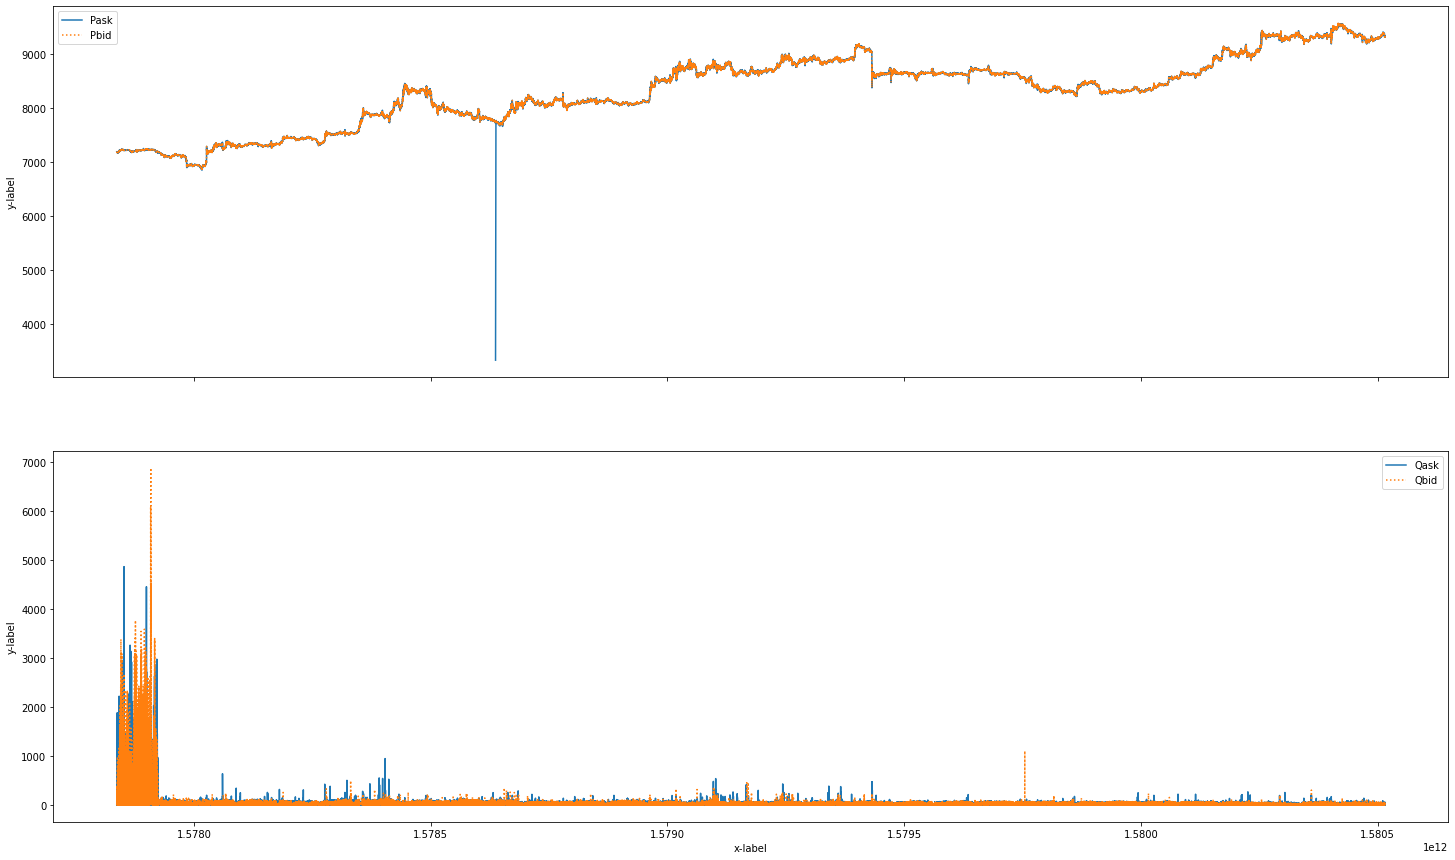

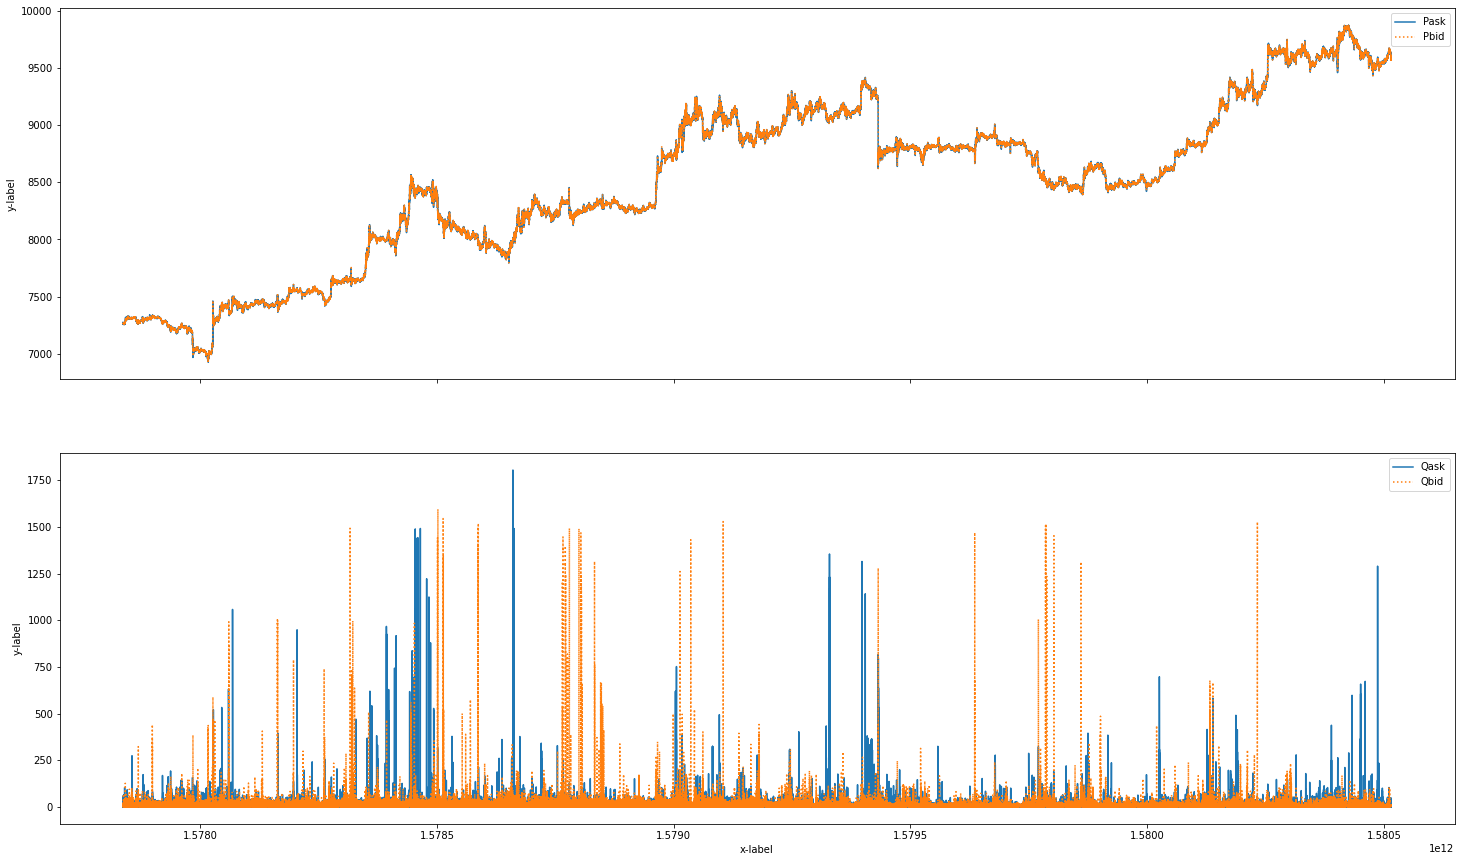

In [ ]:
import matplotlib.pyplot as plt

# 画图出来看看
def visual_ok_data(df_ok):
  x=df_ok['ts'].values
  y_1=df_ok['Pask'].values
  y_2=df_ok['Pbid'].values
  y_3=df_ok['Qask'].values
  y_4=df_ok['Qbid'].values

  fig, axs = plt.subplots(2, figsize=(25,15))

  axs[0].plot(x, y_2, label="Pask")
  axs[0].plot(x, y_1, ':', label="Pbid")

  axs[1].plot(x, y_3, label="Qask")
  axs[1].plot(x, y_4, ':', label="Qbid")

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')
      ax.label_outer()
      ax.legend()

visual_ok_data(df_okswap)
visual_ok_data(df_okef)

# Define Dataset

## Non-aggregated dataset

In [ ]:
import tensorflow as tf

# 用前WINDOW_SIZE-1个数据+第WINDOW_SIZE的时间戳打包来预测第WINDOW_SIZE的数据, 并分开返回
def create_dl_pairs(window):
  # [第WINDOW_SIZE的时间戳作]*5
  next_ts=tf.reshape(tf.dtypes.cast(tf.repeat(window[-1:][0][-1], repeats=5), tf.float32), [1, 5])
  print("next_ts", next_ts, type(next_ts), next_ts.shape)
  print("window[:-1]", window[:-1], type(window[:-1]), window[:-1].shape)
  data=tf.concat([window[:-1], next_ts], axis=0)
  label=window[-1:][0][:-1]
  return (data, label)

# 用前WINDOW_SIZE-1个数据+第WINDOW_SIZE的时间戳打包来预测第WINDOW_SIZE的数据, 但只返回预测数据
def create_data(window):
  next_ts=tf.reshape(tf.dtypes.cast(tf.repeat(window[-1:][0][-1], repeats=5), tf.float32), [1, 5])
  print("next_ts", next_ts, type(next_ts), next_ts.shape)
  print("window[:-1]", window[:-1], type(window[:-1]), window[:-1].shape)
  data=tf.concat([window[:-1], next_ts], axis=0)
  # label=window[-1:][0][:-1]
  return data

# 使用window函数将数据处理成每WINDOW_SIZE个一组, 每组偏移一个index
tensor_okswap=tf.constant(df_okswap.values, dtype=tf.float32)
data_okswap=tf.data.Dataset.from_tensor_slices(tensor_okswap).window(WINDOW_SIZE, shift=1, drop_remainder=True)

# [How to use windows created by the Dataset.window() method in TensorFlow 2.0?](https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0)
data_okswap=data_okswap.flat_map(lambda window: window.batch(WINDOW_SIZE))

# 使用zip函数将预测数据与预测目标打包
data_okswap=data_okswap.map(create_data)
label_okswap=tf.data.Dataset.from_tensor_slices(tf.constant(df_okswap.values[WINDOW_SIZE:], dtype=tf.float32))
ds_okswap=tf.data.Dataset.zip((data_okswap, label_okswap)).batch(BATCH_SIZE).cache()

print(type(ds_okswap), tensor_okswap.shape)
stop_num=1
# X为预测数据, y为预测目标
for X, y in ds_okswap:
  if stop_num>10:
    break
  print("Input:", type(X), X.numpy(), X.shape, "Target:", type(y), y.numpy(), y.shape)
  stop_num+=1

next_ts Tensor("Reshape_1:0", shape=(1, 5), dtype=float32) <class 'tensorflow.python.framework.ops.Tensor'> (1, 5)
window[:-1] Tensor("strided_slice_3:0", shape=(None, 5), dtype=float32) <class 'tensorflow.python.framework.ops.Tensor'> (None, 5)
<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'> (5151360, 5)
Input: <class 'tensorflow.python.framework.ops.EagerTensor'> [[[7.1947002e+03 7.1938999e+03 3.1967977e-01 9.0354328e+00 1.5778367e+12]
  [7.1947002e+03 7.1938999e+03 3.1967977e-01 9.0354328e+00 1.5778369e+12]
  [7.1947002e+03 7.1940000e+03 3.1967977e-01 1.7931609e+00 1.5778369e+12]
  ...
  [7.1947002e+03 7.1940000e+03 9.7196548e+01 1.8209620e+00 1.5778369e+12]
  [7.1947002e+03 7.1940000e+03 9.7196548e+01 1.7931609e+00 1.5778369e+12]
  [1.5778369e+12 1.5778369e+12 1.5778369e+12 1.5778369e+12 1.5778369e+12]]

 [[7.1947002e+03 7.1938999e+03 3.1967977e-01 9.0354328e+00 1.5778369e+12]
  [7.1947002e+03 7.1940000e+03 3.1967977e-01 1.7931609e+00 1.5778369e+12]
  [7.1947002e+03 7

## Aggregated Dataset

In [ ]:
dataset = tf.data.Dataset.range(7).window(3, shift=1, drop_remainder=True)
for window in dataset:
  print(list(window.as_numpy_iterator()))

[0, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]
[4, 5, 6]


In [ ]:
import tensorflow as tf

def create_aggregated_ds(df):
  print("df", type(df), df[:20], df.shape)

  tensor_from_df=tf.constant(df.values, dtype=tf.float32)
  data_all=tf.data.Dataset.from_tensor_slices(tensor_from_df).window(WINDOW_SIZE, shift=1, drop_remainder=True)

  data_all=data_all.flat_map(lambda window: window.batch(WINDOW_SIZE))

  data_pairs=data_all.map(create_dl_pairs)
  data_pairs=data_pairs.batch(BATCH_SIZE).cache()

  return data_pairs

# 将同1s钟的数据聚合并求平均
def aggregate_data_1s(df):
  df['time']=pd.to_datetime(df['ts'], unit='ms')
  df=df.set_index('time',drop=True)
  pask_series=(df.Pask.resample('1s').mean()).fillna(method="bfill")
  pbid_series=(df.Pbid.resample('1s').mean()).fillna(method="bfill")
  qask_series=(df.Qask.resample('1s').mean()).fillna(method="bfill")
  qbid_series=(df.Qbid.resample('1s').mean()).fillna(method="bfill")

  df=pd.concat([pask_series, pbid_series, qask_series, qbid_series], axis=1)

  return df

def create_dl_pairs(window):
  return (window[:-1], window[-1:][0])

df_agg_okef=aggregate_data_1s(df_okef)
data_okef=create_aggregated_ds(df_agg_okef)
print(type(data_okef))
# data_okswap=create_aggregated_ds(df_okef)

stop_num=1
for X, y in data_okef:
  if stop_num>1:
    break
  print("Input:", type(X), X.numpy(), X.shape, "Target:", type(y), y.numpy(), y.shape)
  stop_num+=1

print(len(list(data_okef)))

df <class 'pandas.core.frame.DataFrame'>                          Pask     Pbid      Qask      Qbid
time                                                      
2020-01-01 00:00:00  7274.040  7274.03  0.137475  3.072575
2020-01-01 00:00:01  7274.040  7274.03  0.185592  3.093196
2020-01-01 00:00:02  7274.040  7274.03  0.137475  3.093196
2020-01-01 00:00:03  7274.040  7274.03  0.137475  3.093196
2020-01-01 00:00:04  7274.040  7274.03  2.288962  3.003837
2020-01-01 00:00:05  7274.040  7274.03  3.814936  2.900730
2020-01-01 00:00:06  7274.040  7274.03  3.759946  2.907604
2020-01-01 00:00:07  7274.040  7274.03  3.423132  2.900730
2020-01-01 00:00:08  7274.040  7274.03  3.416258  2.893857
2020-01-01 00:00:09  7274.040  7274.03  3.753073  2.914478
2020-01-01 00:00:10  7272.315  7272.26  0.343753  0.522573
2020-01-01 00:00:11  7271.530  7271.52  0.887021  0.206284
2020-01-01 00:00:12  7271.530  7271.52  5.246489  2.757333
2020-01-01 00:00:13  7271.530  7271.52  9.365292  2.709200
2020-01-01 00:0

In [ ]:
import math

# 计算数据集中batch数量
ds_size=math.ceil(df_agg_okef.shape[0]/32)

# 分离训练集与测试集
train_okef=data_okef.take(math.ceil(ds_size*TRAIN_RATE*(0.05 if DEBUG else 1)))
test_okef=data_okef.skip(math.ceil(ds_size*TRAIN_RATE*(0.05 if DEBUG else 1))).take(math.ceil(ds_size*(1-TRAIN_RATE)*(0.05 if DEBUG else 1)))

# 分离测试集中的data和label
test_data_okef=test_okef.map(lambda a, b: a)
test_label_okef=test_okef.map(lambda a, b: b)

# Define Model

In [ ]:
from tensorflow.keras import models,layers,losses,metrics,callbacks

class Block(layers.Layer):
  def __init__(self, **kwargs):
    super(Block, self).__init__(**kwargs)

  def call(self, x_input,x):
    #x_input[:,-1,:], 32*7*4->32*4
    x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
    return x_out

  def get_config(self):  
    config = super(Block, self).get_config()
    return config

In [ ]:
lstm=layers.LSTM(128, input_shape=(7, 4))
lstm=layers.LSTM(128, return_sequences=True, input_shape=(7, 4))

print(type(data_okef))

#(32, 7, 4) & (32, 4)
x_input, y_label=next(iter(data_okef))

predict=lstm(x_input)

print("predict:", type(predict), predict.numpy(), predict.shape)

<class 'tensorflow.python.data.ops.dataset_ops.CacheDataset'>
predict: <class 'tensorflow.python.framework.ops.EagerTensor'> [[[-0.7615942   0.          0.         ...  0.7615942   0.53116673
   -0.        ]
  [-0.9640276   0.          0.         ...  0.9640276   0.74565023
   -0.        ]
  [-0.9950547   0.          0.         ...  0.9950547   0.7744741
   -0.        ]
  ...
  [-0.99990916  0.          0.         ...  0.99990916  0.7760777
   -0.        ]
  [-0.9999876   0.          0.         ...  0.9999876   0.7744935
   -0.        ]
  [-0.99999833  0.          0.         ...  0.99999833  0.7745051
   -0.        ]]

 [[-0.7615942   0.          0.         ...  0.7615942   0.53085303
   -0.        ]
  [-0.9640276   0.          0.         ...  0.9640276   0.7457346
   -0.        ]
  [-0.9950547   0.          0.         ...  0.9950547   0.77447504
   -0.        ]
  ...
  [-0.99990916  0.          0.         ...  0.99990916  0.77441984
   -0.        ]
  [-0.9999876   0.          0.      

In [ ]:
tf.keras.backend.clear_session()

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__(name='my_model')
    # LSTM层, 输入数据shape为7*4, 输出数据shape为128
    self.lstm_1=layers.LSTM(4, return_sequences=True, input_shape=(7,4))
    self.lstm_2=layers.LSTM(4, return_sequences=True, input_shape=(7,4))
    self.lstm_3=layers.LSTM(4, input_shape=(7, 4))
    # self.lstm_1 = layers.Dense(5)
    # self.lstm_2 = layers.Dense(5)
    # self.lstm_3 = layers.Dense(5)
    # 全连接层, 输出数据shape为4
    self.dense = layers.Dense(4)
    self.block = Block()

  def call(self, inputs):
    # Define your forward pass here,
    # using layers you previously defined (in `__init__`).
    x=self.lstm_1(inputs)
    x=self.lstm_2(x)
    x=self.lstm_3(x)
    x=self.dense(x)
    return x
    # return self.block(inputs, x)

model = MyModel()

In [ ]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
  def call(self,y_true,y_pred):
    err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
    mean_err_percent = tf.reduce_mean(err_percent)
    return mean_err_percent

  def get_config(self):
    config = super(MSPE, self).get_config()
    return config

In [ ]:
import os

# 存档检查点存放路径
checkpoint_path = Model_DIR+"qf-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Train

In [ ]:
import datetime
import os

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss=MSPE(name = "MSPE"))

# 每5个epoch保存一次模型权重
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

# 日志保存路径
logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback=tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# 每100个epoch没有提升, lr减半
lr_callback=tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=100)
# 每200个epoch没有提升, 停止训练
stop_callback=tf.keras.callbacks.EarlyStopping(monitor="loss", patience=200)
callbacks_list=[tb_callback, lr_callback, stop_callback, cp_callback]

history=model.fit(train_okef, epochs=EPOCH_NUM, callbacks=callbacks_list)

Epoch 1/500
3348/3348 [==============================] - 31s 9ms/step - loss: 0.5533 - lr: 0.0100
Epoch 2/500
3348/3348 [==============================] - 31s 9ms/step - loss: 0.5464 - lr: 0.0100
Epoch 3/500
3348/3348 [==============================] - 31s 9ms/step - loss: 0.5451 - lr: 0.0100
Epoch 4/500
3348/3348 [==============================] - 31s 9ms/step - loss: 0.5436 - lr: 0.0100
Epoch 5/500
3345/3348 [============================>.] - ETA: 0s - loss: 0.5422
Epoch 00005: saving model to /content/gdrive/My Drive/crypto_data/models/qf-0005.ckpt
3348/3348 [==============================] - 31s 9ms/step - loss: 0.5422 - lr: 0.0100
Epoch 6/500
3348/3348 [==============================] - 32s 9ms/step - loss: 0.5407 - lr: 0.0100
Epoch 7/500
3348/3348 [==============================] - 31s 9ms/step - loss: 0.5393 - lr: 0.0100
Epoch 8/500
3348/3348 [==============================] - 31s 9ms/step - loss: 0.5380 - lr: 0.0100
Epoch 9/500
3348/3348 [==============================] - 31s 9

# Load Model

In [ ]:
# 读取检查点路径中最新的模型参数
latest=tf.train.latest_checkpoint(checkpoint_dir)


model = MyModel()
# 加载保存的模型参数
model.load_weights(latest)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss=MSPE(name = "MSPE"), 
              metrics=['mse'])

# Re-evaluate the model
loss, mse = model.evaluate(test_okef, verbose=2)
print("Restored model, mse: {:5.2f}".format(mse))


# model.summary()

In [ ]:
print(list(test_data_okef.as_numpy_iterator())[0], list(test_data_okef.as_numpy_iterator())[0].shape)
print(list(test_data_okef.as_numpy_iterator())[0][:,-1,:])

test_predict_label=model.predict(test_data_okef, batch_size=32)
# print(type(test_data_okef), len(list(test_data_okef)))
# print(type(test_predict_label), len(list(test_predict_label)))
# print(type(test_label_okef), len(list(test_label_okef)))

test_label_okef_numpy=np.stack(test_label_okef.unbatch().as_numpy_iterator(), axis=0)

print("test_predict_label", test_predict_label[:20], test_predict_label.shape)
print("test_label_okef_numpy", test_label_okef_numpy[:20], test_label_okef_numpy.shape)

print(test_predict_label[:, 0], test_label_okef_numpy[:, 0])

[[[7.2179199e+03 7.2179102e+03 3.1865135e-01 6.2552733e+00]
  [7.2167402e+03 7.2165898e+03 8.6394634e+00 1.3856892e-01]
  [7.2165498e+03 7.2165400e+03 1.0219564e+01 9.6306539e-01]
  [7.2165498e+03 7.2165400e+03 3.5889726e+00 3.2148371e+00]
  [7.2165498e+03 7.2165400e+03 3.4434736e+00 2.8684106e+00]
  [7.2165498e+03 7.2165400e+03 3.2979748e+00 1.8291314e+00]
  [7.2165498e+03 7.2165400e+03 3.5889726e+00 9.7692245e-01]]

 [[7.2167402e+03 7.2165898e+03 8.6394634e+00 1.3856892e-01]
  [7.2165498e+03 7.2165400e+03 1.0219564e+01 9.6306539e-01]
  [7.2165498e+03 7.2165400e+03 3.5889726e+00 3.2148371e+00]
  [7.2165498e+03 7.2165400e+03 3.4434736e+00 2.8684106e+00]
  [7.2165498e+03 7.2165400e+03 3.2979748e+00 1.8291314e+00]
  [7.2165498e+03 7.2165400e+03 3.5889726e+00 9.7692245e-01]
  [7.2165498e+03 7.2165400e+03 3.5889726e+00 1.2332780e+00]]

 [[7.2165498e+03 7.2165400e+03 1.0219564e+01 9.6306539e-01]
  [7.2165498e+03 7.2165400e+03 3.5889726e+00 3.2148371e+00]
  [7.2165498e+03 7.2165400e+03 3.443

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


[[4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-02]
 [4.5603296e+03 4.5603296e+03 3.8095102e-02 2.7050680e-0

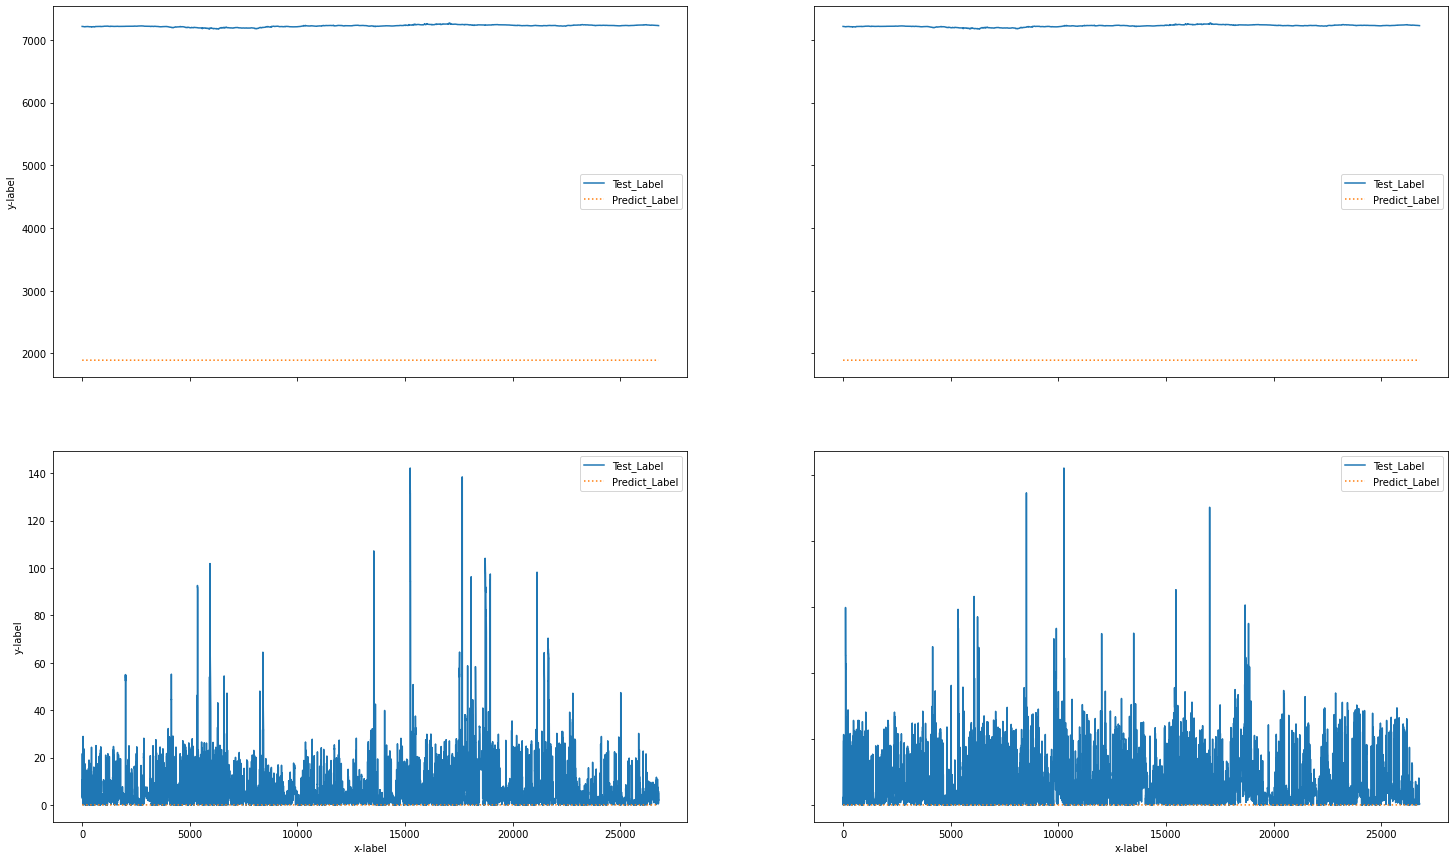

In [ ]:
import matplotlib.pyplot as plt

# 可视化比较测试集中预测目标和真实目标
def visual_test_comparision(test_label, predict_label):

  test_len=test_label.shape[0]

  x=np.arange(test_len)


  fig, axs = plt.subplots(2, 2, figsize=(25,15))

  axs[0, 0].plot(x, test_label[:,0], label="Test_Label")
  axs[0, 0].plot(x, predict_label[:,0], ':', label="Predict_Label")

  axs[0, 1].plot(x, test_label[:,1], label="Test_Label")
  axs[0, 1].plot(x, predict_label[:,1], ':', label="Predict_Label")

  axs[1, 0].plot(x, test_label[:,2], label="Test_Label")
  axs[1, 0].plot(x, predict_label[:,2], ':', label="Predict_Label")

  axs[1, 1].plot(x, test_label[:,3], label="Test_Label")
  axs[1, 1].plot(x, predict_label[:,3], ':', label="Predict_Label")

  for ax in axs.flat:
      ax.set(xlabel='x-label', ylabel='y-label')
      ax.label_outer()
      ax.legend()

test_label_okef_numpy=np.stack(list(test_label_okef.unbatch().as_numpy_iterator()), axis=0)
visual_test_comparision(test_label_okef_numpy, test_predict_label)



# print(test_predict_label, test_predict_label.shape, type(test_predict_label), type(test_predict_label[0]))
# print(test_label_okef_numpy, test_label_okef_numpy.shape, type(test_label_okef_numpy), type(test_label_okef_numpy[0]))

# print(test_label_okef_numpy[:, 0])